#### autoencoder (AE) is a neural network with two families of functions : the encoder family Eφ :x->z , parameterized by φ and decoder family Dθ : z->x parameterized by θ. Autoencoders try to create a smaller feature vector representation of input data such as images, which is called "bottleneck", using a first NN called encoder , and then reconstruct it by a second neural network called the decoder

In [17]:
!pip install torch torchvision pytorch_lightning>=1.4

100%|██████████| 170M/170M [00:03<00:00, 56.2MB/s]


label: cat


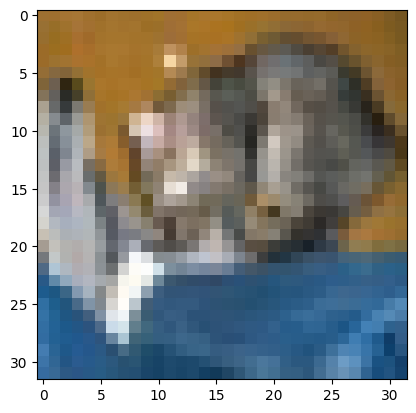

label: ship


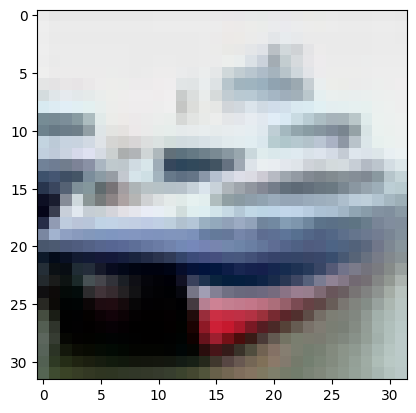

label: ship


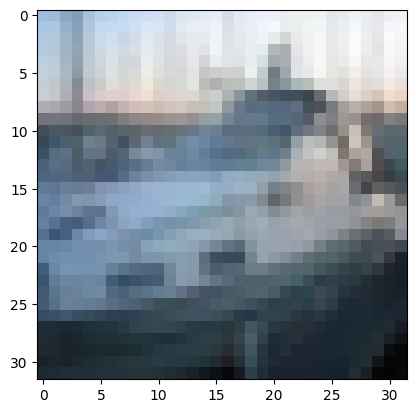

label: airplane


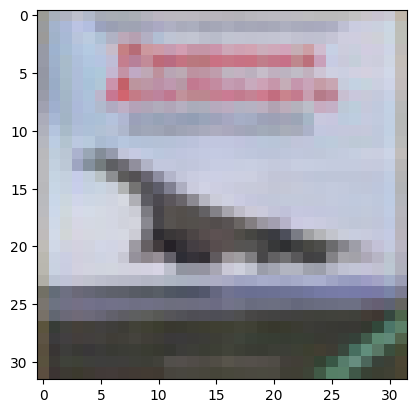

label: frog


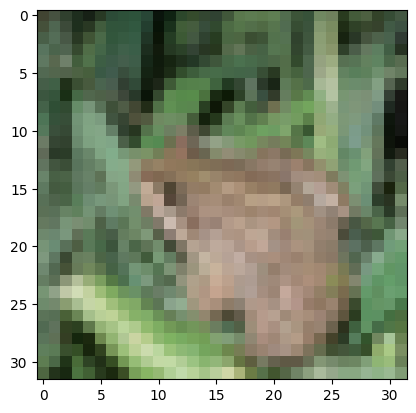

In [18]:
# lets first view the cifar dataset
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt

test_data = CIFAR10(root='./view',train=False,download=True)

def view (i):
  img,label = test_data[i]
  print(f"label: {test_data.classes[label]}")
  plt.imshow(img)
  plt.show()

for i in range(5):
  view(i)

In [19]:
# creating the dataset for the model--we will be using cifar10 dataset
import torch
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import pytorch_lightning as pl

# lets define the transformation that transforms our data to pytorch tensor and then normalize to -1 to 1 instead of 0 to 1

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

DATASET_PATH = './data'
train_dataset = CIFAR10(root=DATASET_PATH,train=True,transform = transform, download=True)
pl.seed_everything(42)
trans_set,val_set = torch.utils.data.random_split(train_dataset,[45000,5000])

test_set = CIFAR10(root=DATASET_PATH,train = False, transform=transform, download=True)

#defining the data loaders
train_loader = torch.utils.data.DataLoader(trans_set,batch_size=256,shuffle=True,drop_last=True,pin_memory=True,num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=256,shuffle=False,drop_last=True,pin_memory=True,num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=256,shuffle=True,drop_last=True,pin_memory=True,num_workers=4)

# getting just the image tensors
def get_train_images(num):
  return torch.stack([train_dataset[i][0] for i in range(num)])


100%|██████████| 170M/170M [00:04<00:00, 39.4MB/s]
INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#### an autoencoder consists of an encoder that maps the input x to a lower dimensional feature vector z and a decoder that reconstructs X̂ from z . we train the model by comparing x to X̂ and optimizing the parameters to increase the similarity between x and X̂.